# Stock Price Prediction using LSTM (Final Version)

## 1) Imports

In [15]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

## 2) Download Data (or load CSV)

In [24]:
ticker = "AAPL"
data = yf.download(ticker, start="2010-01-01", end="2024-12-31")
data.to_csv('../data/aapl_raw.csv')  # optional save

data = pd.read_csv('../data/aapl_raw.csv', index_col=0, parse_dates=True)

# Flatten columns if they're multi-indexed
data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]

# Make sure all values are numeric
data = data.apply(pd.to_numeric, errors='coerce')


/var/folders/bw/2gpjdk9513ld5ztszs8b000m0000gn/T/ipykernel_13220/3921446270.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2010-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed
/var/folders/bw/2gpjdk9513ld5ztszs8b000m0000gn/T/ipykernel_13220/3921446270.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('../data/aapl_raw.csv', index_col=0, parse_dates=True)


## 3) Feature Engineering

In [25]:
# Add Technical Indicators
data['EMA_20'] = ta.ema(data['Close'], length=20)
data['EMA_50'] = ta.ema(data['Close'], length=50)
data['RSI_14'] = ta.rsi(data['Close'], length=14)

# Drop NaNs created by indicators
data.dropna(inplace=True)

## 4) Data Preparation

In [26]:
# Select features
features = ['Close', 'EMA_20', 'EMA_50', 'RSI_14']
data = data[features]

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create Sequences
sequence_length = 60

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i][0])  # Close is first column
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, sequence_length)

# Train-test split (time-based split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## 5) Build LSTM (best config)

In [27]:
def build_lstm_model(units=100, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = build_lstm_model()

/Users/calebgomez/Desktop/Stock Price Prediction/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 6) Train Model

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0031 - val_loss: 6.6422e-04
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 2.5036e-04 - val_loss: 0.0017
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 2.5285e-04 - val_loss: 2.2660e-04
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 1.8580e-04 - val_loss: 0.0012
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 1.4927e-04 - val_loss: 4.6439e-04
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 1.9881e-04 - val_loss: 5.4666e-04
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 1.4959e-04 - val_loss: 9.8740e-04
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 1.2734e-04 - val_loss: 2.0533e-04
Epoch 9/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 1.1949e-04 - val_loss: 1.6423e-04
Epoch 10/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 1.6744e-04 - val_loss: 2.8567e-04
Epoch 11/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss

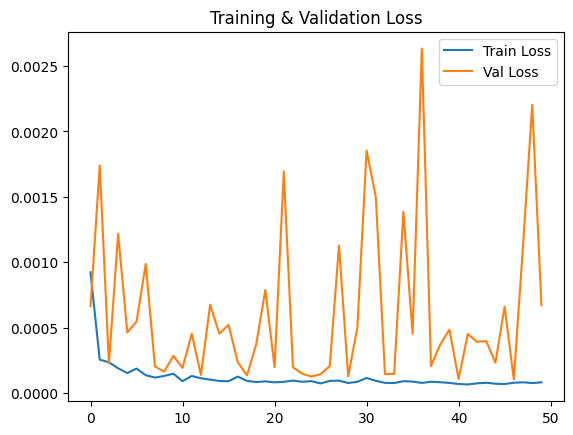

In [28]:
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1)

# Plot training loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

## 7) Make Predictions

In [29]:
y_pred = model.predict(X_test)

# Inverse transform
y_pred_scaled = np.zeros((len(y_pred), data.shape[1]))
y_test_scaled = np.zeros((len(y_test), data.shape[1]))
y_pred_scaled[:, 0] = y_pred[:, 0]
y_test_scaled[:, 0] = y_test
y_pred_actual = scaler.inverse_transform(y_pred_scaled)[:, 0]
y_test_actual = scaler.inverse_transform(y_test_scaled)[:, 0]

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


## 8) Evaluation

In [30]:
mse = mean_squared_error(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)

print(f"Test MSE: {mse:.2f}")
print(f"Test MAE: {mae:.2f}")

Test MSE: 65.35
Test MAE: 7.40


## 9) Pretty Plot

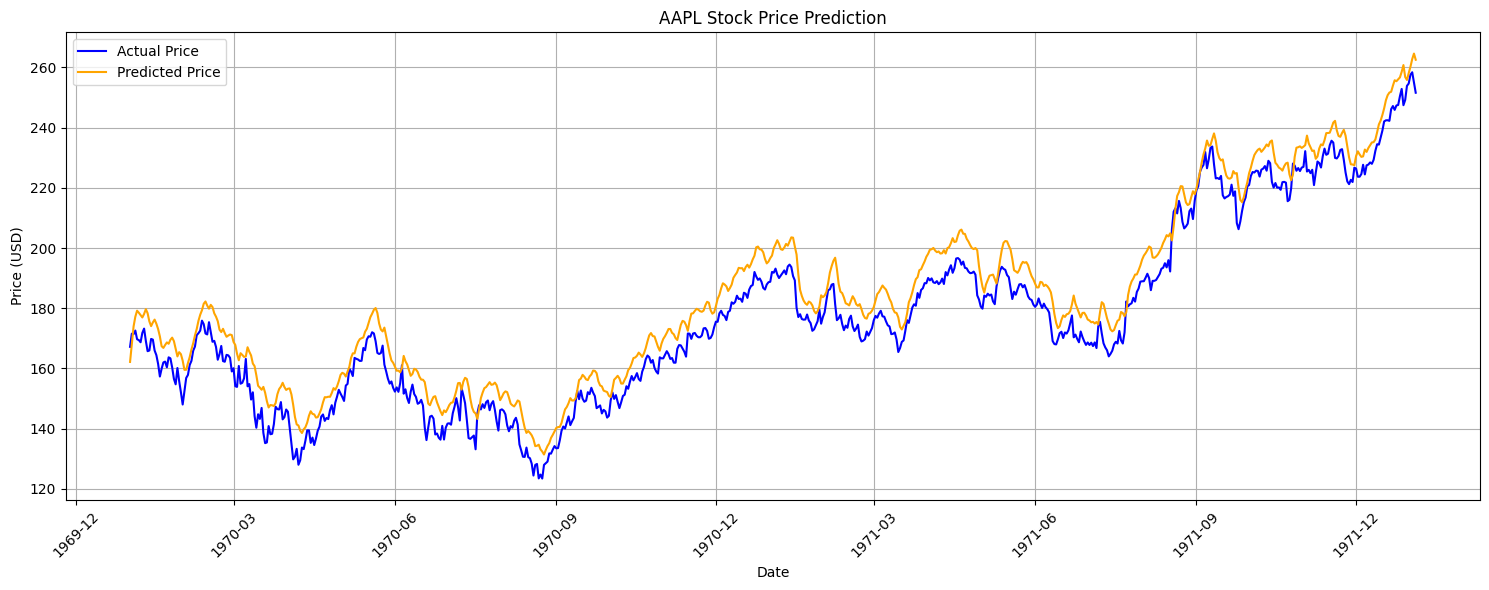

In [34]:
# Match dates
full_dates = data.index
test_start_index = len(full_dates) - len(y_test_actual)
test_dates = full_dates[test_start_index:]

plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test_actual, label="Actual Price", color='blue')
plt.plot(test_dates, y_pred_actual, label="Predicted Price", color='orange')
plt.title("AAPL Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Save plot
plt.savefig('../visuals/final_evaluation_plot.png', dpi=300)

plt.show()

In [33]:
model.save('../models/final_lstm_model.keras')